<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

Features that are classified FIXED (Not-Renovate-able):
MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
YearBuilt
YearRemodAdd
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
Bedroom
Kitchen
TotRmsAbvGrd
Functional
Fireplaces
GarageType
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscFeature 
MiscVal
YrSold
SaleType
SaleCondition








### Question 1 -- Perform cleaning, feature engineering, and EDA

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Question 2 -- Filter out the non-residential homes

Mask to filter out residential homes from the data

In [5]:
mask = (house['MSZoning'] == 'RH') | (house['MSZoning'] == 'RL') \
| (house['MSZoning'] == 'RP') | (house['MSZoning'] == 'RM')\
| (house['MSZoning'] == 'FV')

In [6]:
house = house[mask]

In [7]:
house.reset_index(inplace=True,drop=True)

In [8]:
house.shape

(1450, 81)

In [9]:
house.drop(labels=['Id'],inplace=True,axis=1)

In [10]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Three of the features that are continuous variables contain NaN values that must be edited. This section looks at the distribution of values amongst these features to see if replacing them with some descriptive statistic (i.e. the mean, mode) will make some sense.

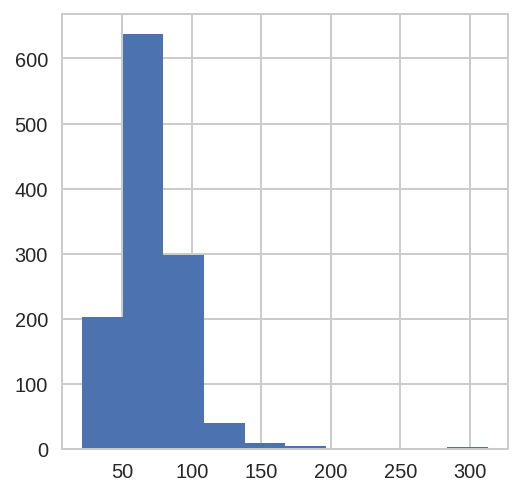

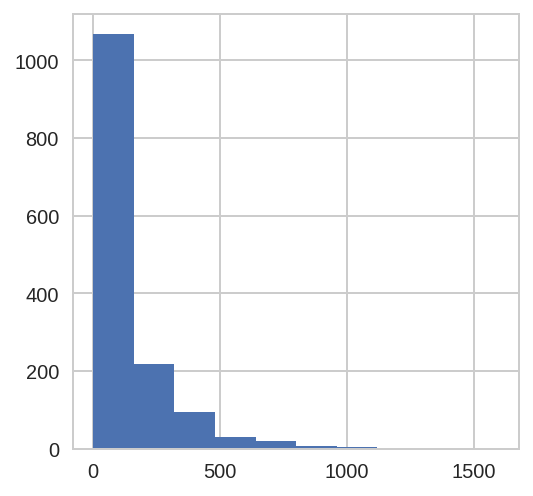

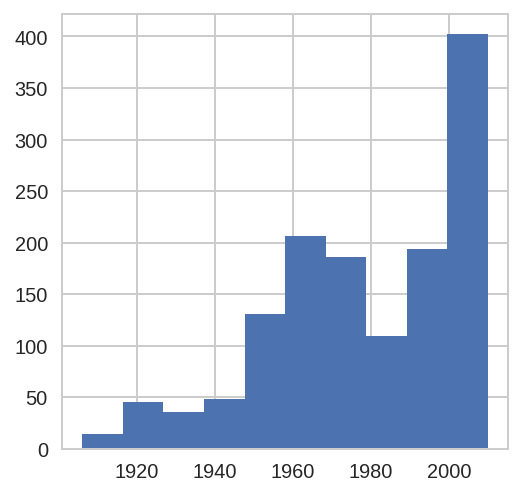

In [11]:
# house.isnull().sum()
plt.figure(figsize=(4,4))
house['LotFrontage'].hist()
plt.figure(figsize=(4,4))
house['MasVnrArea'].hist()
plt.figure(figsize=(4,4))
house['GarageYrBlt'].hist()

The distribution of data is skewed for the features in question -- It therefore makes sense to replace the NaN values in these cases with the Mode of the data set.

In [12]:
house['LotFrontage'].fillna(house['LotFrontage'].mode()[0],inplace=True)
house['MasVnrArea'].fillna(house['MasVnrArea'].mode()[0],inplace=True)
house['GarageYrBlt'].fillna(house['GarageYrBlt'].mode()[0], inplace=True)

### Question 3 - Identify 'fixed' features that can predict house price

In [13]:
fixed_features = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape',
                  'LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
                  'Condition2','BldgType','HouseStyle','YearBuilt','MasVnrArea','Foundation',
                  'BsmtCond','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                  'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
                  'KitchenAbvGr','TotRmsAbvGrd','Functional','Fireplaces','GarageType','GarageYrBlt',
                  'GarageCars','GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                  '3SsnPorch','ScreenPorch','PoolArea','MiscFeature','MiscVal','MoSold','YrSold',
                  'SaleType','SaleCondition']

In [14]:
# Extract the renovatable features
renovatable_features = []
for cols in house.columns:
    if cols not in fixed_features:
        renovatable_features.append(cols)
    # Ensure YrSold added to renovatables
    if cols == 'YrSold':
        renovatable_features.append(cols)


In [15]:
house_fixed = pd.DataFrame(house[fixed_features])
house_fixed['SalePrice'] = house['SalePrice']

In [16]:
# Adds Variables that should change type to categorical
categorical_cols = []
numeric_cols = []
for feature in house_fixed.columns:
    if house_fixed[feature].dtype == 'O':
        categorical_cols.append(feature)
        house_fixed[feature] = house_fixed[feature].astype('category')
    elif feature == 'MSSubClass':
        categorical_cols.append(feature)
        house_fixed[feature] = house_fixed[feature].astype('category')
    else:
        numeric_cols.append(feature)

Get dummies on categorical columns

In [17]:
house_fixed = pd.get_dummies(data=house_fixed,columns=categorical_cols, dummy_na=True)


### Question 4 -- Train a model on pre-2010 data and evaluate its performance on the 2010 houses

### PCA 
A principal component analysis was conducted on the data as a form of feature engineering. The goal of this section was to calculate the first few components of the data, and then include them as additional features before fitting the model. This was inspired by the medium article that was shared by the instructors. An important note to using PCA is that YOU MUST FIRST SCALE THE DATA. Initially I performed PCA on unscaled data and resulted in having only one significant principal component. Having only one component explain the majority of the variance is a good indicator that data may not be scaled.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
scaler = StandardScaler()

In [20]:
X_sc = scaler.fit_transform(house_fixed[numeric_cols].drop('SalePrice',axis=1))

In [21]:
X_sc

array([[-0.14574457, -0.20720224,  1.04646605, ..., -0.08717302,
        -1.59878098,  0.14148226],
       [ 0.52542722, -0.09230257,  0.14683615, ..., -0.08717302,
        -0.48656328, -0.61274301],
       [-0.01151021,  0.07255347,  0.9798268 , ..., -0.08717302,
         0.99639365,  0.14148226],
       ..., 
       [-0.10099978, -0.14805389, -1.01935077, ...,  4.9383075 ,
        -0.48656328,  1.6499328 ],
       [-0.01151021, -0.08061278, -0.71947414, ..., -0.08717302,
        -0.85730251,  1.6499328 ],
       [ 0.30170329, -0.05863197, -0.21967974, ..., -0.08717302,
        -0.11582405,  0.14148226]])

In [22]:
pca = PCA(n_components=4)
pca.fit(X_sc)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
pc_df = pd.DataFrame(pca.transform(house_fixed[numeric_cols].drop('SalePrice',axis=1)),
             columns=['PC_{}'.format(num) for num in range(1,5)])

In [24]:
pca.explained_variance_ratio_

array([ 0.19746199,  0.09901   ,  0.07094078,  0.0607066 ])

Append the Principal components to the original scaled DataFrame

In [25]:
pc_df.shape

(1450, 4)

In [26]:
house_fixed.shape

(1450, 195)

In [27]:
house_fixed_final = pd.concat([house_fixed, pc_df],axis=1)

In [28]:
house_fixed_final.shape

(1450, 199)

Evaluate only if skipping PCA

In [29]:
#house_fixed_final = house_fixed

### Split into train and test based on the Year Sold

In [30]:
year_2010_mask = house_fixed['YrSold'] == 2010

house_fixed_train = house_fixed_final[~year_2010_mask]
house_fixed_test = house_fixed_final[year_2010_mask]

In [31]:
house_fixed_train.shape

(1278, 199)

In [32]:
house_fixed_test.shape

(172, 199)

In [33]:
X_train = house_fixed_train.drop('SalePrice',axis=1)
yy_train = house_fixed_train['SalePrice']

X_test = house_fixed_test.drop('SalePrice',axis=1)
yy_test = house_fixed_test['SalePrice']

In [34]:
print('Features TRAINING set shape: {}'.format(X_train.shape))
print('Target TRAINING set shape: {}'.format(yy_train.shape))
print('Features TEST set shape: {}'.format(X_test.shape))
print('Target TEST set shape: {}'.format(yy_test.shape))

Features TRAINING set shape: (1278, 198)
Target TRAINING set shape: (1278,)
Features TEST set shape: (172, 198)
Target TEST set shape: (172,)


### Create and test a couple models -- use Lasso, Elastic, RandomForest

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LassoCV, SGDRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, classification_report, auc, make_scorer, precision_recall_curve

### Final Model --- RFE
This model was selected going forward for Problem 2. The final pipeline is outlined in the diagram below. The data is scaled with StandardScaler and the number of features selected for the model was trimmed to the most important 150 features using the Recursive Feature Elimination transformer. Finally, the data is fit using a Random Forest Regressor.

Optional: load model from pickle

In [36]:
gs_rfe_pipe = joblib.load('fixed_random_forrest_regressor.pkl') 

In [37]:
# rfe_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('feature_selection', RFE(estimator=RandomForestRegressor()) ),
#     ('regressor', RandomForestRegressor())
# ])

# rfe_params = {
#     'feature_selection__estimator': [RandomForestRegressor()],
#     'feature_selection__n_features_to_select': [150],
#     'regressor__n_estimators': [300],
#     'regressor__max_features':['log2'],
#     'regressor__max_depth':[35]
# }

# gs_rfe_pipe = GridSearchCV(rfe_pipe,
#                            param_grid=rfe_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=1)

# gs_rfe_pipe.fit(X_train, yy_train)

In [38]:
print(gs_rfe_pipe.best_params_)
print(gs_rfe_pipe.score(X_train, yy_train))
print(gs_rfe_pipe.score(X_test,yy_test))

{'feature_selection__estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False), 'feature_selection__n_features_to_select': 150, 'regressor__max_depth': 35, 'regressor__max_features': 'log2', 'regressor__n_estimators': 300}
0.97598718566
0.865434762216


The model is serialized below as a Python pickle.

In [39]:
#joblib.dump(gs_rfe_pipe, 'fixed_random_forrest_regressor.pkl') 

Many models were explored to see what would be the best predictor of sales price given a home's fixed features. The following blocks of code explored different regression models and feature selection transformers, however, these were not ultimately selected, but are here as a reference. 

## For Reference ONLY
________________________________________________________________________________________________

## Model 1A -- SGD Regression

In [40]:
# dtsgd_pipe = Pipeline([
#     ('skb', SelectKBest(score_func=f_regression)),
#     ('scaler', StandardScaler()),
#     ('sfm', SelectFromModel( estimator=ElasticNet() ) ),
#     ('clf', SGDRegressor())
# ])

# dtsgd_params = {
# #     'skb__k':[60,70],
#     'skb__k': [72, 75, 77],
#     'sfm__estimator':[ElasticNet(alpha=a, l1_ratio=l) for a in np.logspace(-4,-3,5) for l in np.linspace(.1,.9,10)],
# #     'sfm__estimator':[Lasso(alpha=a) for a in np.logspace(-6,-5,5)]
# #     'clf__max_depth': [71, 72, 73],
# #     'clf__max_depth':[35,40,45]
#     'clf__penalty': ['l1', 'l2']
    
# }

# gs_dtsgd_pipe = GridSearchCV(dtsgd_pipe,
#                            param_grid=dtsgd_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=0)

# gs_dtsgd_pipe.fit(X_train, yy_train)

# gs_dtsgd_pipe.best_params_

# gs_dtsgd_pipe.score(X_train, yy_train)

# gs_dtsgd_pipe.score(X_test,yy_test)

## Model 2 -- RandomForest Regression

In [41]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import Lasso, ElasticNet, SGDRegressor
# from sklearn.pipeline import Pipeline

# dtr_pipe = Pipeline([
#     ('skb', SelectKBest(score_func=f_regression)),
#     ('scaler', StandardScaler()),
#     ('sfm', SelectFromModel(estimator=ElasticNet())),
#     ('clf', RandomForestRegressor(n_jobs=-1))
# ])

# dtr_params = {
# #     'skb__k':[60,70],
#     'skb__k': [72, 75, 77],
# #     'sfm__estimator':[ElasticNet(alpha=a, l1_ratio=l) for a in np.logspace(-4,-3,5) for l in np.linspace(.1,.9,10)],
#     'sfm__estimator':[Lasso(alpha=a) for a in np.logspace(-6,-5,5)],
#     'clf__max_depth': [71, 72, 73],
# #     'clf__max_depth':[35,40,45]
    
# }

# gs_dtr_pipe = GridSearchCV(dtr_pipe,
#                            param_grid=dtr_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=0)

# gs_dtr_pipe.fit(X_train, yy_train)

# gs_dtr_pipe.best_params_

# gs_dtr_pipe.score(X_train, yy_train)

# gs_dtr_pipe.score(X_test,yy_test)

## Model 3 -------- Linear Regression con L1 Regularization

In [42]:
# dtl_pipe = Pipeline([
#     ('skb', SelectKBest(score_func=f_regression)),
#     ('scaler', StandardScaler()),
#     ('sfm', SelectFromModel(estimator=Lasso())),
#     ('lr', Lasso())
# ])
# dtl_params = {
#     'skb__k':[50, 51, 52],
#     'sfm__estimator':[Lasso(), ElasticNet()],
#     'lr__alpha': np.logspace(-4,2,9)
    
# }

# gs_dtl_pipe = GridSearchCV(dtl_pipe,
#                            param_grid=dtl_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=1)

# gs_dtl_pipe.fit(X_train, yy_train)

# gs_dtl_pipe.score(X_train,yy_train)

# gs_dtl_pipe.score(X_test,yy_test)

## Reference End
________________________________________________________________________________________________

### 5) Characterize your model. How well does it perform? What are the best estimates of price?

Based on the scores from the training and test sets above, I'm confident that the model is accurately predicting home sales price. The trained model ended up with an accuracy close to 98%, while the test score was closer to 87%. It can be argued that the model is slightly overfitting the data because of it's near-perfect training score, but I'm not too concerned at the moment considering that the test score for predicting 2010 home sale prices was still relatively good. 

The following steps will show the most important features that were determined from the model.

Verify that the sum of the feature importances add to 1, indicating that each feature importance represents a percentage of the total sum.


In [43]:
sum(gs_rfe_pipe.best_estimator_.named_steps['regressor'].feature_importances_)

1.0000000000000002

Grab the 150 features that were selected from the Recursive Feature Elimination Step

In [44]:
feat_mask = pd.Series(gs_rfe_pipe.best_estimator_.named_steps['feature_selection'].support_)
feat=X_train.columns[feat_mask]

Plot the top 20 features

In [45]:
xgb_feat_imps = gs_rfe_pipe.best_estimator_.named_steps['regressor'].feature_importances_
# col_names = ["col_{}".format(i) for i in range(1,20)]
col_names = X_train.columns[feat_mask]
feats_df = pd.DataFrame(list(zip(col_names, xgb_feat_imps)), columns= ['col_name','importance'])

In [46]:
top_20_feats = feats_df.sort_values('importance',ascending=False)[:20]

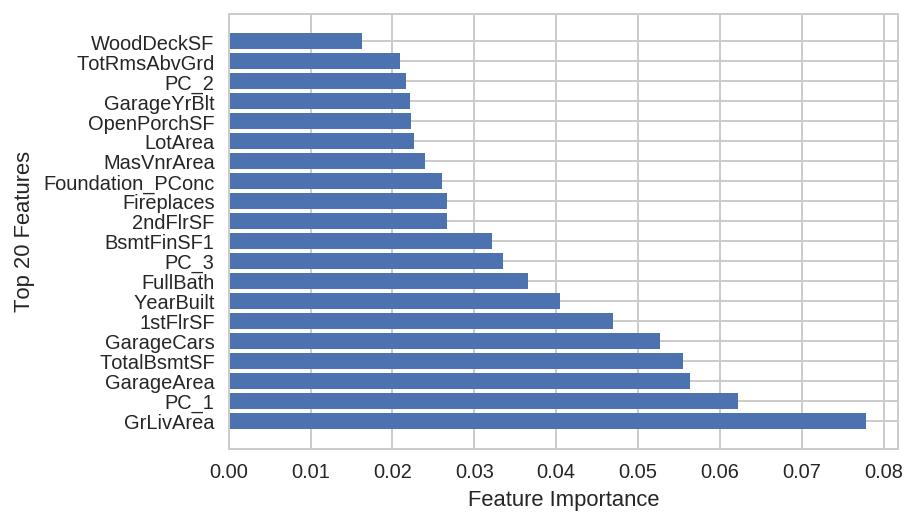

In [47]:
fig, ax = plt.subplots()
ax.barh(range(top_20_feats.shape[0]), top_20_feats['importance'], align='center')
ax.set_yticks(np.arange(top_20_feats.shape[0]))
ax.set_yticklabels(top_20_feats['col_name'])
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Top 20 Features')
plt.show()

The plot above shows the top 20 features most important to predicting the sales price of a home. By observing the first few indicators we can see there is a trend for the type of features that are important in prediction. Features like above ground living area ('GrLivArea'), garage area, total basement area, and first floor area are all metrics that evaluate the home space in square-feet. This is something that intuitively makes sense -- the larger a home is, the more valuable it is likely to be. More surprisingly, we can see that the principal components that were feature engineered appear in the top twenty. PC1 comes in second, while PC3 and PC2 also make the list. Although we can only guess what quality is really being measured by these features, it is validating to see that the principal components calculated were capturing the data's highest explained variance and therefore are likely candidates for the creation of predictors. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Question 1: Evaluate the effect in dollars of the renovate-able features
For this question, I create a model using the renovate-able features that were defined earlier in this notebook to predict the residuals calculated from the model in Problem 1

In [48]:
# A:
residuals_train = yy_train - gs_rfe_pipe.predict(X_train)
residuals_test = yy_test - gs_rfe_pipe.predict(X_test)

In [49]:
residuals_test.shape

(172,)

In [50]:
residuals_train.shape

(1278,)

In [51]:
house_renovatable = pd.DataFrame(house[renovatable_features])
house_renovatable['SalePrice'] = house['SalePrice']

In [52]:
house_renovatable.shape

(1450, 28)

In [53]:
house_renovatable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 28 columns):
OverallQual     1450 non-null int64
OverallCond     1450 non-null int64
YearRemodAdd    1450 non-null int64
RoofStyle       1450 non-null object
RoofMatl        1450 non-null object
Exterior1st     1450 non-null object
Exterior2nd     1450 non-null object
MasVnrType      1442 non-null object
ExterQual       1450 non-null object
ExterCond       1450 non-null object
BsmtQual        1413 non-null object
BsmtExposure    1412 non-null object
BsmtFinType1    1413 non-null object
BsmtFinType2    1412 non-null object
Heating         1450 non-null object
HeatingQC       1450 non-null object
CentralAir      1450 non-null object
Electrical      1449 non-null object
LowQualFinSF    1450 non-null int64
KitchenQual     1450 non-null object
FireplaceQu     769 non-null object
GarageFinish    1371 non-null object
GarageQual      1371 non-null object
GarageCond      1371 non-null object
PoolQC    

In [54]:
# Adds Variables that should change type to categorical
categorical_cols = []
numeric_cols = []
for feature in house_renovatable.columns:
    if house_renovatable[feature].dtype == 'O':
        categorical_cols.append(feature)
        house_renovatable[feature] = house_renovatable[feature].astype('category')
    else:
        numeric_cols.append(feature)


In [55]:
house_renovatable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 28 columns):
OverallQual     1450 non-null int64
OverallCond     1450 non-null int64
YearRemodAdd    1450 non-null int64
RoofStyle       1450 non-null category
RoofMatl        1450 non-null category
Exterior1st     1450 non-null category
Exterior2nd     1450 non-null category
MasVnrType      1442 non-null category
ExterQual       1450 non-null category
ExterCond       1450 non-null category
BsmtQual        1413 non-null category
BsmtExposure    1412 non-null category
BsmtFinType1    1413 non-null category
BsmtFinType2    1412 non-null category
Heating         1450 non-null category
HeatingQC       1450 non-null category
CentralAir      1450 non-null category
Electrical      1449 non-null category
LowQualFinSF    1450 non-null int64
KitchenQual     1450 non-null category
FireplaceQu     769 non-null category
GarageFinish    1371 non-null category
GarageQual      1371 non-null category
GarageCon

In [56]:
house_renovatable = pd.get_dummies(data=house_renovatable, columns=categorical_cols, dummy_na=True)

In [57]:
house_renovatable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Columns: 153 entries, OverallQual to Fence_nan
dtypes: int64(6), uint8(147)
memory usage: 276.2 KB


In [58]:
year_2010_mask = house_renovatable['YrSold'] == 2010

house_renovatable_train = house_renovatable[~year_2010_mask]
house_renovatable_test = house_renovatable[year_2010_mask]

In [59]:
X_train = house_renovatable_train.drop('SalePrice',axis=1)
X_test = house_renovatable_test.drop('SalePrice',axis=1)

In [60]:
print('Features TRAINING set shape: {}'.format(X_train.shape))
print('Target TRAINING set shape: {}'.format(residuals_train.shape))
print('Features TEST set shape: {}'.format(X_test.shape))
print('Target TEST set shape: {}'.format(residuals_test.shape))

Features TRAINING set shape: (1278, 152)
Target TRAINING set shape: (1278,)
Features TEST set shape: (172, 152)
Target TEST set shape: (172,)


Create Model Using Same Pipeline from Problem 1

In [61]:
gs_renovate_pipe = joblib.load('renovate_random_forrest_regressor.pkl') 

In [62]:
# renovate_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('feature_selection', RFE(estimator=RandomForestRegressor()) ),
#     ('regressor', RandomForestRegressor())
# ])

# renovate_params = {
#     'feature_selection__estimator': [RandomForestRegressor()],
#     'feature_selection__n_features_to_select': [150],
#     'regressor__n_estimators': [300],
#     'regressor__max_features':['log2','auto'],
#     'regressor__max_depth':[60]
# }

# gs_renovate_pipe = GridSearchCV(renovate_pipe,
#                            param_grid=renovate_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=1)

# gs_renovate_pipe.fit(X_train, yy_train)

In [63]:
print(gs_renovate_pipe.best_params_)
print(gs_renovate_pipe.score(X_train, yy_train))
print(gs_renovate_pipe.score(X_test, yy_test))

{'feature_selection__estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False), 'feature_selection__n_features_to_select': 150, 'regressor__max_depth': 60, 'regressor__max_features': 'auto', 'regressor__n_estimators': 300}
0.966485172797
0.782212235907


The model is serialized below as a Python pickle.

In [64]:
# joblib.dump(gs_renovate_pipe, 'renovate_random_forrest_regressor.pkl') 

## For Reference ONLY

_______________

In [65]:
# renovate_pipe = Pipeline([
#     ('skb', SelectKBest(score_func=f_regression)),
#     ('scaler', StandardScaler()),
#     ('sfm', SelectFromModel( estimator=ElasticNet() ) ),
#     ('clf', SGDRegressor())
# ])

# renovate_params = {
# #     'skb__k':[60,70],
#     'skb__k': [72, 75, 77],
#     'sfm__estimator':[ElasticNet(alpha=a, l1_ratio=l) for a in np.logspace(-4,-3,5) for l in np.linspace(.1,.9,10)],
# #     'sfm__estimator':[Lasso(alpha=a) for a in np.logspace(-6,-5,5)]
# #     'clf__max_depth': [71, 72, 73],
# #     'clf__max_depth':[35,40,45]
#     'clf__penalty': ['l1', 'l2']
    
# }

# gs_renovate_pipe = GridSearchCV(renovate_pipe,
#                            param_grid=renovate_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=0)

# gs_renovate_pipe.fit(X_train, yy_train)

# gs_renovate_pipe.best_params_

# print(gs_renovate_pipe.score(X_train, yy_train))
# print(gs_renovate_pipe.score(X_test, yy_test))

In [66]:
# dtsgd_pipe = Pipeline([
#     ('skb', SelectKBest(score_func=f_regression)),
#     ('scaler', StandardScaler()),
#     ('sfm', SelectFromModel( estimator=ElasticNet() ) ),
#     ('clf', SGDRegressor())
# ])

# dtsgd_params = {
# #     'skb__k':[60,70],
#     'skb__k': [72, 75, 77],
#     'sfm__estimator':[ElasticNet(alpha=a, l1_ratio=l) for a in np.logspace(-4,-3,5) for l in np.linspace(.1,.9,10)],
# #     'sfm__estimator':[Lasso(alpha=a) for a in np.logspace(-6,-5,5)]
# #     'clf__max_depth': [71, 72, 73],
# #     'clf__max_depth':[35,40,45]
#     'clf__penalty': ['l1', 'l2']
    
# }

# gs_dtsgd_pipe = GridSearchCV(dtsgd_pipe,
#                            param_grid=dtsgd_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=0)

# gs_dtsgd_pipe.fit(X_train, yy_train)
# gs_dtsgd_pipe.best_params_


# print(gs_dtsgd_pipe.score(X_train, yy_train))
# print(gs_dtsgd_pipe.score(X_test,yy_test))


_____

### Question 2: How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have build to determine if they can make money

The first model that was created predicts the sales price of a home based on the features that were deemed 'fixed'. In the second model, the sales price is predicted from the 'renovatable' parts of the home. The combination of these two models can be used by the company to determine if buying a property would turn over profit. By using the first model, the company can estimate the value of a home, let's say for example \$100,000. This would be the price that the company would pay to buy a home. The second model can then be used to estimate the sales price of that same home after a series of renovations take place. For example, let's say that the company invests in some renovations in the home thereby raising the quality of the bathrooms and the garage conditions. The raised conditions predict the sales price of the home to be \$120,000. Therefore, the company could sell the home at \$120,000. The company would then make money if the cost of the renovations did not exceed the \$20,000 increased value of the home.

### Question 3: Investigate how much of the variance in price remaining is explained by these features.

The variance in the price remaining from the first model were calculated as the residuals in an earlier step of this notebook and are plotted below.

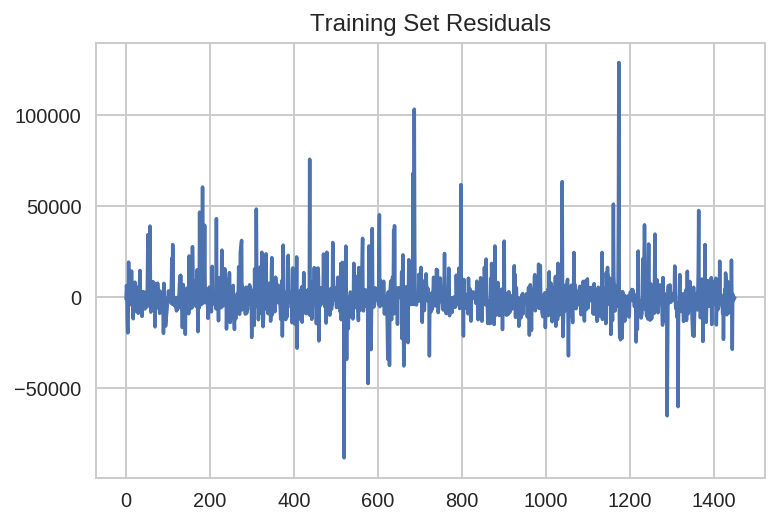

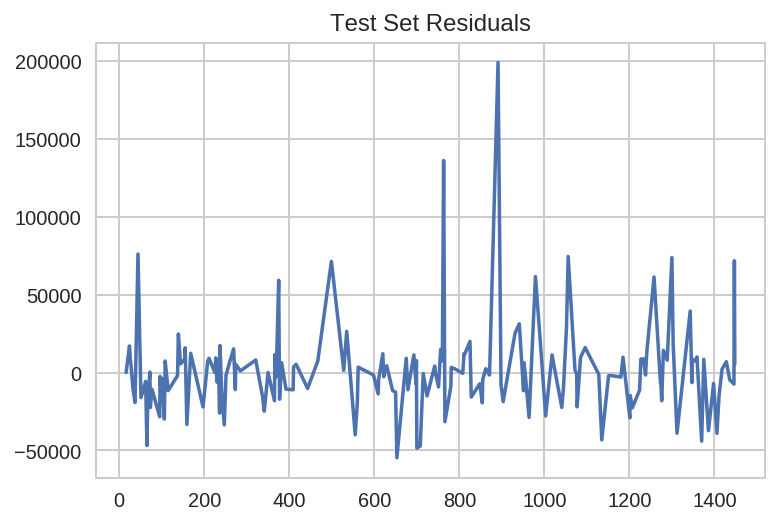

In [75]:
plt.plot(residuals_train)
plt.title('Training Set Residuals')
plt.figure()
plt.plot(residuals_test)
plt.title('Test Set Residuals')

In [78]:
print(np.std(residuals_train))
print(np.std(residuals_test))

12251.5907021
29220.2686314


The residuals between the model from Part 1 and the data are quite substantial in some of the cases. While most of the residuals fall within \$5000 of the actual test data, some exceed as high as $200000.

### Question 4: Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

Not sure if I trust my model yet. I would like to have more time to find a better fitting model -- the test data scored 78% accuracy. I would be more comfortable to have a more accurate model in order to justify the difference in residuals from my first model. With more time, I probably could try some additional feature engineering to overcome this gap and to confidently describe the variance in the data.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

### Question 1: Determine which features predict the 'Abnorml' category in the 'SaleCondition' feature

For answering this question, a new model was built. Instead of using just renovatable or fixed features, all features were included in the model. A gradient boosting model was fit to the data and the top twenty important features were identified. The following section outlines the data prepping of the original housing data in the DataFrame 'house'

In [79]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [80]:
# Adds Variables that should change type to categorical
categorical_cols = []
numeric_cols = []
for feature in house.columns:
    if house[feature].dtype == 'O':
        categorical_cols.append(feature)
        house[feature] = house[feature].astype('category')
    else:
        numeric_cols.append(feature)
categorical_cols.remove('SaleCondition')

In [81]:
X_ = house.drop('SaleCondition',axis=1)
yy_= house['SaleCondition']

In [82]:
X_ = pd.get_dummies(X_, columns=categorical_cols, dummy_na=True)

In [83]:
type(X_)

pandas.core.frame.DataFrame

In [84]:
type(yy_)

pandas.core.series.Series

The following encodes the target feature 'SaleCondition' such that the abnormal sales are assigned to the value 1, and all others are assinged to the value of 0

In [85]:
yy_ = yy_.apply(lambda x: 1 if x == 'Abnorml' else 0)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_,yy_,random_state=0) 

In [87]:
y_test = pd.Series(y_test)
y_train = pd.Series(y_train)

In [88]:
type(X_test)

pandas.core.frame.DataFrame

In [89]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1087, 324)
(1087,)
(363, 324)
(363,)


Create boosted model to predict the home SaleCondition

In [90]:
import xgboost as xgb

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load pre-trained model from pickle

In [91]:
gs_clf_pipe = joblib.load('SaleCondition_clf.pkl') 

In [92]:
# clf_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('clf', xgb.XGBClassifier())
# ])

# clf_params ={
#     'clf__max_depth':[1,3,5],
#     'clf__learning_rate':[.1,.5],
#     'clf__n_estimators':[100,250]
# }

# gs_clf_pipe = GridSearchCV(clf_pipe,
#                            param_grid=clf_params,
#                            cv=ShuffleSplit(n_splits=5, random_state=42),
#                            n_jobs = -1,
#                            verbose=1)
# gs_clf_pipe.fit(X=X_train, y=y_train)

In [93]:
print(gs_clf_pipe.best_params_)
print(gs_clf_pipe.score(X_train,y_train))
print(gs_clf_pipe.score(X_test,y_test))

{'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 250}
0.945722171113
0.914600550964


Saved model

In [94]:
# joblib.dump(gs_clf_pipe, 'SaleCondition_clf.pkl') 

The following code is used to rank the feature importance and to display the top twenty features that contributed to predicting the abnormal sale condition.

In [95]:
xgb_feat_imps = gs_clf_pipe.best_estimator_.named_steps['clf'].feature_importances_
# col_names = ["col_{}".format(i) for i in range(1,20)]
col_names = X_.columns
feats_df = pd.DataFrame(list(zip(col_names, xgb_feat_imps)), columns= ['col_name','importance'])

In [96]:
top_20_feats = feats_df.sort_values('importance',ascending=False)[:20]

In [97]:
top_20_feats

,col_name,importance
36,SalePrice,0.116
314,SaleType_COD,0.084
10,BsmtUnfSF,0.068
11,TotalBsmtSF,0.064
5,YearBuilt,0.052
24,GarageYrBlt,0.036
34,MoSold,0.036
322,SaleType_WD,0.036
2,LotArea,0.036
61,LotConfig_Corner,0.032


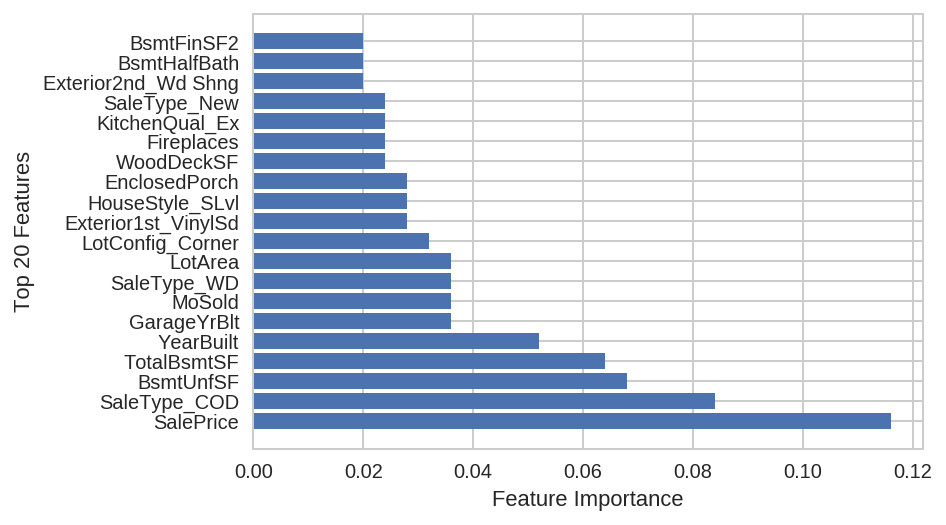

In [98]:
fig, ax = plt.subplots()
ax.barh(range(top_20_feats.shape[0]), top_20_feats['importance'], align='center')
ax.set_yticks(np.arange(top_20_feats.shape[0]))
ax.set_yticklabels(top_20_feats['col_name'])
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Top 20 Features')
plt.show()

In [99]:
gs_clf_pipe.best_estimator_.named_steps['clf']

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=nan, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Question 2: Justify your results

This was actually more simple than I thought it would be. Using a gradient-boosted model on the entire dataset, I was able to train a model that achieved 94.5% model accuracy with the training data, and 91% accuracy with the test set. IN this particular approach, no special feature engineering was done. The data was prepared such that the model only predicts if the sale was abnormal or not -- it does not give any insights to a sale condition other than abnormal. From the plot of the top 20 features above, we see that sales price was a strong indicator on the abnormality of the sale. This makes a lot of sense -- since abnormal sales probably correlated strongly with lower sales prices.

_______________________

Note to instructor: There was a lot more work that I would like to have done to this notebook, but I simply ran out of time. For future work, I would plot more EDA to explore some of the features in greater detail and to give some insights into more clever ways to feature engineering. It would have been instresting to see if ONLY the PCA components were used in the model generation, if that would have yeilded higher scores. I was also inclined to explore the use of polynomial features to see if that had the same desired effect as including the PCA components that I did earlier. In general, I spent too much time on trying out different types of machine learning models that didn't yeild satisfactory scores. Will probably build on the future work I've outlined here for preparing my portfolio.